In [49]:
import os
import glob
from pathlib import Path

import bz2
import pickle
import _pickle as cPickle

# import multiprocessing
import multiprocess as mp
import pandas as pd
import numpy as np
import seaborn as sns
import itertools
import matplotlib.pyplot as plt
import pickle

from scipy.spatial.distance import squareform, pdist
from matplotlib.backends.backend_pdf import PdfPages
plt.rcParams['figure.dpi'] = 300
import sys
import matplotlib.backends.backend_pdf
import skimage

## Specify working directory and other parametes

In [65]:
# find current working directoy
cwd_path = Path().absolute()
# get the absolute pathway to data storage
data_root = cwd_path.parent.parent / "data"

# markers we consider and cell types we need to check
markers = [ 'CPSF6', 'ATRX', 'H4K8ac', 'HDAC2', 'H3K9ac',
       'H3K9me3', 'H3K9me2', 'RNAPIISer2-P', 'H3', 'H3K36me2', 'UBTF',
       'LaminB1', 'RNAPIISer5-P', 'RYBP', 'HP1beta', 'RING1B', 'H2A.X',
       'H3K4me1', 'H4K20me2', 'H3K27me2', 'JARID2', 'SF3A66', 'CBP',
       'H2AK119u1', 'EZH2', 'H3K4me2', 'BRG1', 'HP1alpha', 'Fibrillarin',
       'KAP1', 'H3K27ac', 'H3K4me3', 'H3K36ac', 'H3K14ac', 'H4K20me1',
       'HP1gamma', 'H4K20me3', 'H3K27me3', 'mH2A1', 'CHD4', 'KAT3B/p300',
       'H3K56ac', 'H3K36me3', 'HDAC1', 'SUZ12', 'H4K16ac', 'n_rad_score',
       'n_per_dist(um)', 'ITS1_RNA', 'Rnu2_RNA', 'polyA_RNA',
       'Malat1_RNA', "MajSat"]

cell_types_all = ["Bergmann", "Purkinje", "MLI1", "MLI2+PLI", "E14", "NMuMG"]

# Read meta data

In [51]:
chrom_list = [f"chr{x}" for x in range(1, 20)]

# get the coordinate in the order of distance matrix
coord = pd.read_csv(str(data_root / "annotation" / "2020-09-20-NewBalance-loci-paint-barcodes.csv"))[["name", "paint"]]
bin_annot = pd.read_csv(str(data_root / "annotation"/"LC1-100k-25kb-100kb-200kb-paint-mm10-annotation.csv"))
coord = coord.merge(bin_annot)
coord = coord[coord["chrom"] != "chrX"]
paint_coord = coord.groupby(["paint", "chrom"]).agg({"start" : "min", "end" : "max", "200kb name": list, "100kb name": list, "name" : list}).reset_index()
paint_coord["x_coord"] = paint_coord["paint"] - 1
paint_coord["chrom_id"] = paint_coord["chrom"].str[3:].astype(int)

# chromosome mask is generated to only consider inter or intra chromosome distances
chrom_id = paint_coord["chrom_id"].values[:, None]
intra_chrom_mask = squareform(pdist(chrom_id)) == 0
inter_chrom_mask = squareform(pdist(chrom_id)) > 0

mtx_size = inter_chrom_mask.shape[0]

# calculate using the H4K20me3 peaks
H4K20me3_annot = pd.read_csv(str(data_root / "cerebellum" / "peak_detection" /"H4K20me3-peaks-H4K20me5_cat5-weak1-strong2.csv"))

# grab bins at paint resolution with any 200kb bins defined to be strong H4K20me3 bins
H4_coord = coord.merge(H4K20me3_annot[["200kb name", "H4K20me3_cat5"]])
H4_coord["H4K20me3_strong"] = 0
H4_coord.loc[H4_coord["H4K20me3_cat5"] == 2,"H4K20me3_strong" ] = 1
H4_coord = H4_coord.groupby("paint")["H4K20me3_strong"].apply(max).reset_index()

# read in gene family annotation
gene_family_annot = pd.read_csv(str( data_root / "annotation" /"LC1-100k-mm10-gene-family-paint-bin.csv") )
gene_family_annot = paint_coord.merge(gene_family_annot, how = "left")
# check those gene familys
check_gf = ["Cyp", "Slc", "Olfr", "Zfp", "Vmn"]

## Read in Immunoflourescence marker ensemble z-score, exclude chromosome X in this step

In [52]:
# read all celltypes information in cerebellum experiment
leidens = ["0+1", "2", "4", "6+11", "7"]
cell_types = ["Granule", "Bergmann", "MLI1", "Purkinje", "MLI2+PLI"]
df_dict = {}
for ld, ct in zip(leidens, cell_types):
    # start a container for dataframes
    file = str(data_root / "cerebellum" / "IF_ensemble" / f"IF_markers_median_paint_binned_cerebellum_leiden_{ld}.csv")
    # read in all information
    # combine
    df = pd.read_csv(file)
    # save result, remove chrX 
    df_dict[ct] = df.iloc[:mtx_size, :]
    
# take the E14 and NMuMG data
NG_df =  pd.read_csv(str(data_root / "CellCulture" / "IF_ensemble" / "IF_markers_median_paint_binned_NMuMG.csv"))
ES_df = pd.read_csv(str(data_root / "CellCulture" / "IF_ensemble" / "IF_markers_median_paint_binned_E14.csv"))
df_dict["NMuMG"] = NG_df.iloc[:mtx_size, :]
df_dict["E14"] = ES_df.iloc[:mtx_size, :]

## Read in Distance Matrix in paint resolutiopn, exclude chromosome X in this step

In [53]:
# read in all image file
mtx_dict = {}
for ld, ct in zip(["2", "4", "6+11", "7"], ["Bergmann", "MLI1", "Purkinje", "MLI2+PLI"]):
    filename = str(data_root / "distance_matrix" / "mean_outputs_paint_binned" / f"exp_Brain_rep1&2_mean_dists_all_chrm_cluster{ld}.png")
    img_nbrs =  skimage.io.imread(filename)
    missing_pairs = img_nbrs == 65535
    img_nbrs[missing_pairs] = 0
    img_nbrs_microns = img_nbrs/1000
    mtx_dict[ct] = img_nbrs_microns[:, :mtx_size][:mtx_size,:]
    
E14_filename = str(data_root / "distance_matrix" / "mean_outputs_paint_binned" / f"exp_E14_rep1&2_mean_dists_all_chrm.png")
img_nbrs =  skimage.io.imread(E14_filename)
missing_pairs = img_nbrs == 65535
img_nbrs[missing_pairs] = 0
img_nbrs_microns = img_nbrs/1000
mtx_dict["E14"] = img_nbrs_microns[:, :mtx_size][:mtx_size,:]

NG_filename = str(data_root / "distance_matrix" / "mean_outputs_paint_binned" / f"exp_NMuMG_rep1_mean_dists_all_chrm.png")
img_nbrs =  skimage.io.imread(NG_filename)
missing_pairs = img_nbrs == 65535
img_nbrs[missing_pairs] = 0
img_nbrs_microns = img_nbrs/1000
mtx_dict["NMuMG"] = img_nbrs_microns[:, :mtx_size][:mtx_size,:]

# help functions

In [56]:
# for returning data used for ecdf plot
def calc_ecdf(a):    
    x = np.sort(a)
    y = (np.arange(len(x)) + 1)/float(len(x))
    return x, y

# Pickle a file and then compress it into a file with extension 
def compressed_pickle(title, data):
    with bz2.BZ2File(title + ".pbz2", "w") as f: 
        cPickle.dump(data, f)

# Load any compressed pickle file
def decompress_pickle(file):
    data = bz2.BZ2File(file, "rb")
    data = cPickle.load(data)
    return data

## Bootstrap parallely using multicores
## You can run this bootstrap to generate 1000 random sets of 5% bins across genome, you can also skip this step to directly load all interchromosome distance stored in pickle file

In [57]:
# bootstrap 
def calc_chrom_dists(mask, chrom_mask, mtx):
    grid_mask = np.zeros((mask.shape[0], mask.shape[0]))
    grid_mask[mask, :] += 1
    grid_mask[:, mask] += 1
    mask = np.triu(grid_mask, k = 1) == 2
    final_mask = np.logical_and(mask, chrom_mask)
    if final_mask.sum() != 0:
        return mtx[final_mask]
    else:
        return 0

    
def gen_rd_bins(mtx_size, pct, replace = True):
    '''generate random mask along the chromosome bins for bootstrap
    
    Parameters:
    mtx_size: number of chromosome bins
    pct: percentile of selected bins
    '''
    rd_idx = np.unique(np.random.choice(mtx_size, int(mtx_size * pct), replace = replace))
    rd_mask = np.zeros(mtx_size)
    rd_mask[rd_idx] = 1
    return rd_mask > 0

def _draw_bs_reps_chrom_dist(dist_fun, gen_fun, pct, chrom_mask, mtx, bs_size = 1, output = "median", replace = True):
    
    ''' generate random mask along chromosomes
    dist_fun: funtion
        Function that calculate selected distance from the random selected chromosome bins
    
    gen_fun: funtion
        Funciton to randomly draw a subset of chromosome bins
    
    pct: float
        The percentile of selected subset bins
    
    chrom_mask: 
        bolean 2D matrix with the shape the same as the input matrix
        to mask out inter chromosome distance or intra chromosome distance
        
    mtx:
        2D matrix with value from 0 to 1, distance matrix to be examined
        
    bs_size: int, default 1
        number of bootstrap replicates to perform
    
    output: str, "median" or "array"
        output format, either median of selected distance or raw data arrays
    '''
    
    mtx_size = mtx.shape[0]
    
    iterator = range(bs_size)
    if output == "median":
        return np.array([np.median(dist_fun(gen_fun(mtx_size, pct, replace), chrom_mask, mtx)) for _ in iterator])
        
    elif output == "array":
        return [dist_fun(gen_fun(mtx_size, pct, replace), chrom_mask, mtx) for _ in iterator]
    
    else:
        print ("output must be either 'median' or 'array'")
        return None
        
        
def draw_bs_reps_chrom_dist(dist_fun, gen_fun, pct, chrom_mask, mtx, bs_size = 1, n_jobs = 1, output = "median", replace = True):
    
    ''' generate random mask along chromosomes
    dist_fun: funtion
        Function that calculate selected distance from the random selected chromosome bins
    
    gen_fun: funtion
        Funciton to randomly draw a subset of chromosome bins
    
    pct: float
        The percentile of selected subset bins
    
    chrom_mask: 
        bolean 2D matrix with the shape the same as the input matrix
        to mask out inter chromosome distance or intra chromosome distance
        
    mtx:
        2D matrix with value from 0 to 1, distance matrix to be examined
        
    bs_size: int, default 1
        number of bootstrap replicates to perform
    
    n_jobs: int, default 1
        number pf cores to use in drawing bootstrap replicates
    
    output: str, "median" or "array"
        output format, either median of selected distance or raw data arrays
    '''
    # Just call the original function if n_jobs is 1 (no parallelization)
    if n_jobs == 1:
        return _draw_bs_reps_chrom_dist(dist_fun, gen_fun, pct, chrom_mask, mtx, bs_size, output, replace)
    
    # Set up sizes of bootstrap replicates for each core, making sure we
    # get all of them, even if sizes % n_jobs != 0
    bs_sizes = [bs_size // n_jobs for _ in range(n_jobs)]
    bs_sizes[-1] += bs_size - sum(bs_sizes)
    
    # Build arguments
    arg_iterable = [(dist_fun, gen_fun, pct, chrom_mask, mtx, s, output, replace) for s in bs_sizes]
    
    with mp.Pool(n_jobs) as pool:
        result = pool.starmap(_draw_bs_reps_chrom_dist, arg_iterable)
        
    return np.concatenate(result)

### Remove annotation of below block and run to draw random 5% genomic loci, selecte the 5% percentile loci and gene family loci, then calculate inter-chromosome distance of those loci. Or run next block to load interchromosome distances used in this paper
#### Note that this step may take up to 10min

In [73]:
# # interchromosome distance of random loci 
# bs_5per = {}
# for ct in cell_types_all:
#     add_dict = {}
#     bs_arrays = draw_bs_reps_chrom_dist(calc_chrom_dists, gen_rd_bins, 0.05, inter_chrom_mask, mtx_dict[ct], bs_size = 1000, n_jobs = mp.cpu_count(), output = "array", replace = True)
#     medians = []
#     for arr in bs_arrays:    
#         medians.append(np.median(arr))
#     add_dict["array"] = bs_arrays
#     add_dict["median"] = medians
#     bs_5per[ct] = add_dict
    
# # interchromosome distances of top 5% genomic loci for each IF marker
# # chose top 5percentile bins
# n_per = 5
# for ct in cell_types_all:
#     df = df_dict[ct]
#     for m in markers:
#         v = df[m].values
#         if m == "n_per_dist(um)":
#             pct = np.percentile(v, n_per)
#             df.loc[:, f"{m}_binary"] = (v < pct) * 1
#         else:
#             pct = np.max([np.percentile(v, 100 - n_per), 0])
#             df.loc[:, f"{m}_binary"] = (v > pct) * 1

# # extract interchromosome distance of top 5% IF marker bins
# IF_5per = {}
# for ct in cell_types_all:
#     add_dict = {}
#     mtx = mtx_dict[ct]
#     df = df_dict[ct]
#     for m in markers:
#         mask = (df[f"{m}_binary"] == 1).values
#         grid_mask = np.zeros((mask.shape[0], mask.shape[0]))
#         grid_mask[mask, :] += 1
#         grid_mask[:, mask] += 1
#         mask = np.triu(grid_mask, k = 1) == 2
#         final_mask = np.logical_and(mask, inter_chrom_mask)
#         if final_mask.sum() != 0:
#             add_dict[m] = (mtx[final_mask], np.median(mtx[final_mask]))
#     # strong H4K20me3 peak
#     H4_arr = calc_chrom_dists(H4_coord["H4K20me3_strong"].values == 1, inter_chrom_mask, mtx_dict[ct])
#     add_dict["strong H4K20me3"] = (H4_arr, np.median(H4_arr))
#     IF_5per[ct] = add_dict

# # interchromosome distance of loci with gene family 
# gf_dist = {}
# for ct in cell_types_all:
#     add_dict = {}
#     mtx = mtx_dict[ct]    
#     # strong H4K20me3 peak add this here in case you need to compare with gene families
#     H4_arr = calc_chrom_dists(H4_coord["H4K20me3_strong"].values == 1, inter_chrom_mask, mtx_dict[ct])
#     add_dict["strong H4K20me3"] = (H4_arr, np.median(H4_arr))
#     # other
#     for g in check_gf:
#         arr = calc_chrom_dists(gene_family_annot[g].values == 1, inter_chrom_mask, mtx_dict[ct])
#         add_dict[g] = (arr, np.median(arr))
#     gf_dist[ct] = add_dict
    
# # compress and save all information into a pickled file
# final_dict = {}
# final_dict["Random"] = bs_5per
# final_dict["IF"] = IF_5per
# final_dict["Gene family"] = gf_dist

# # save final dict
# compressed_pickle(str(data_root / "cerebellum" / "Fig6" / "Fig6c_interchrom_distance"), final_dict)

# Run this block to load data used in this paper

In [74]:
final_dict = decompress_pickle(str(data_root / "cerebellum" / "Fig6" / "Fig6c_interchrom_distance.pbz2"))
bs_5per = final_dict["Random"]
IF_5per = final_dict["IF"]
gf_dist = final_dict["Gene family"]
del final_dict

# ECDF plot of Fig6c

/Users/yujing/miniconda3/lib/python3.8/site-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


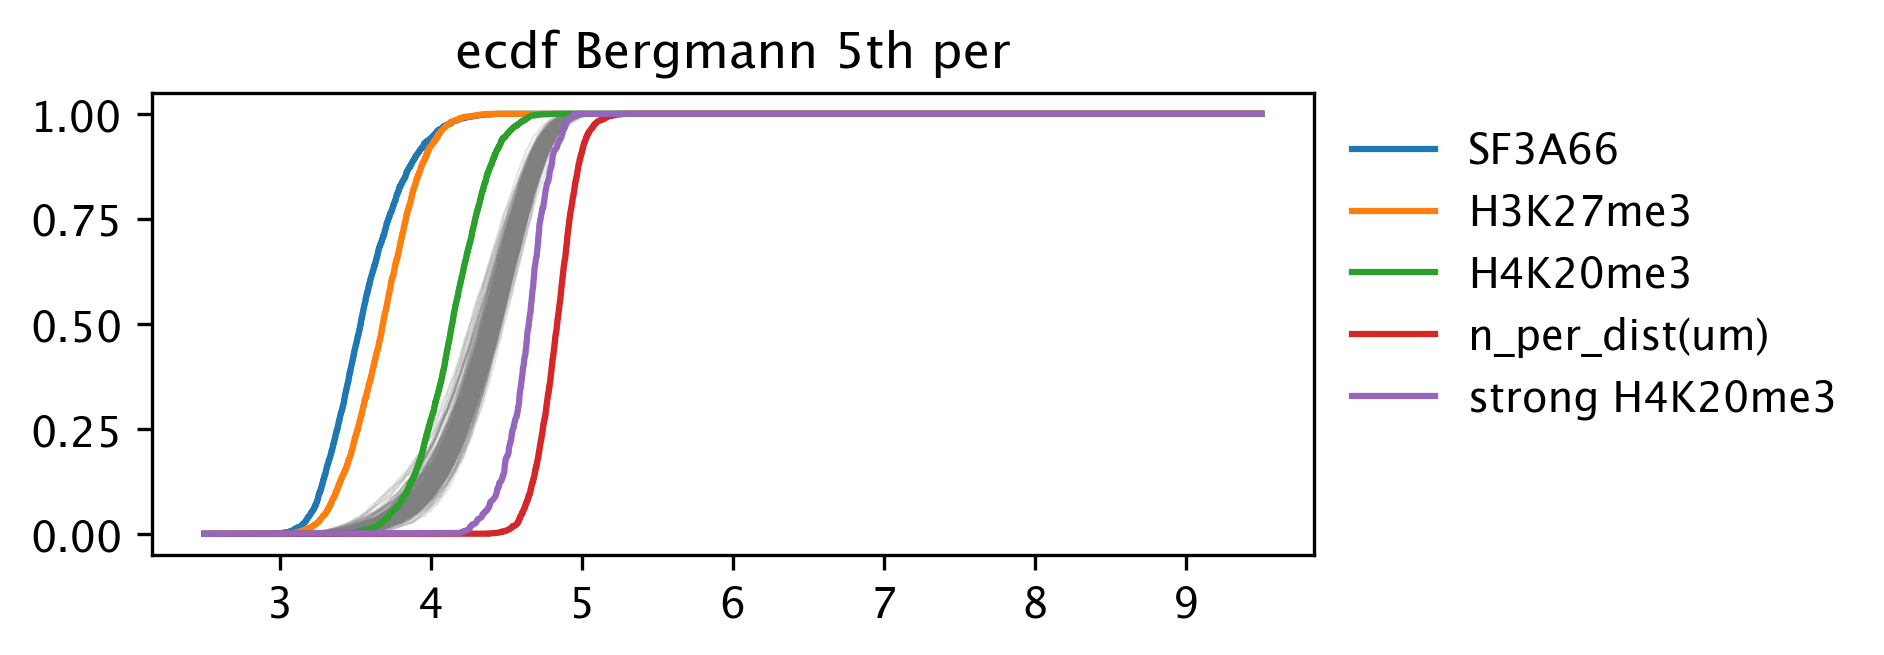

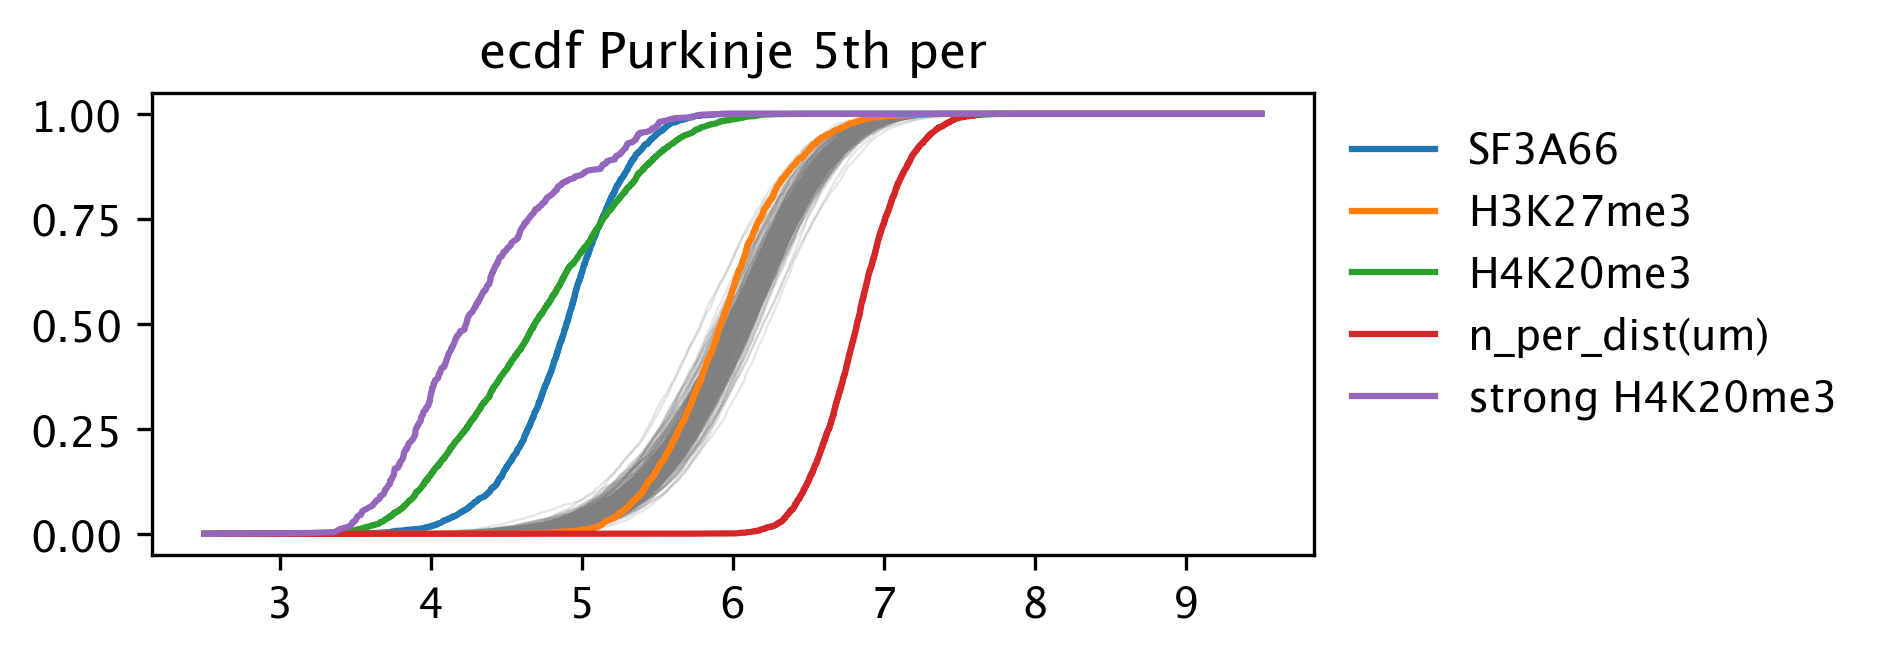

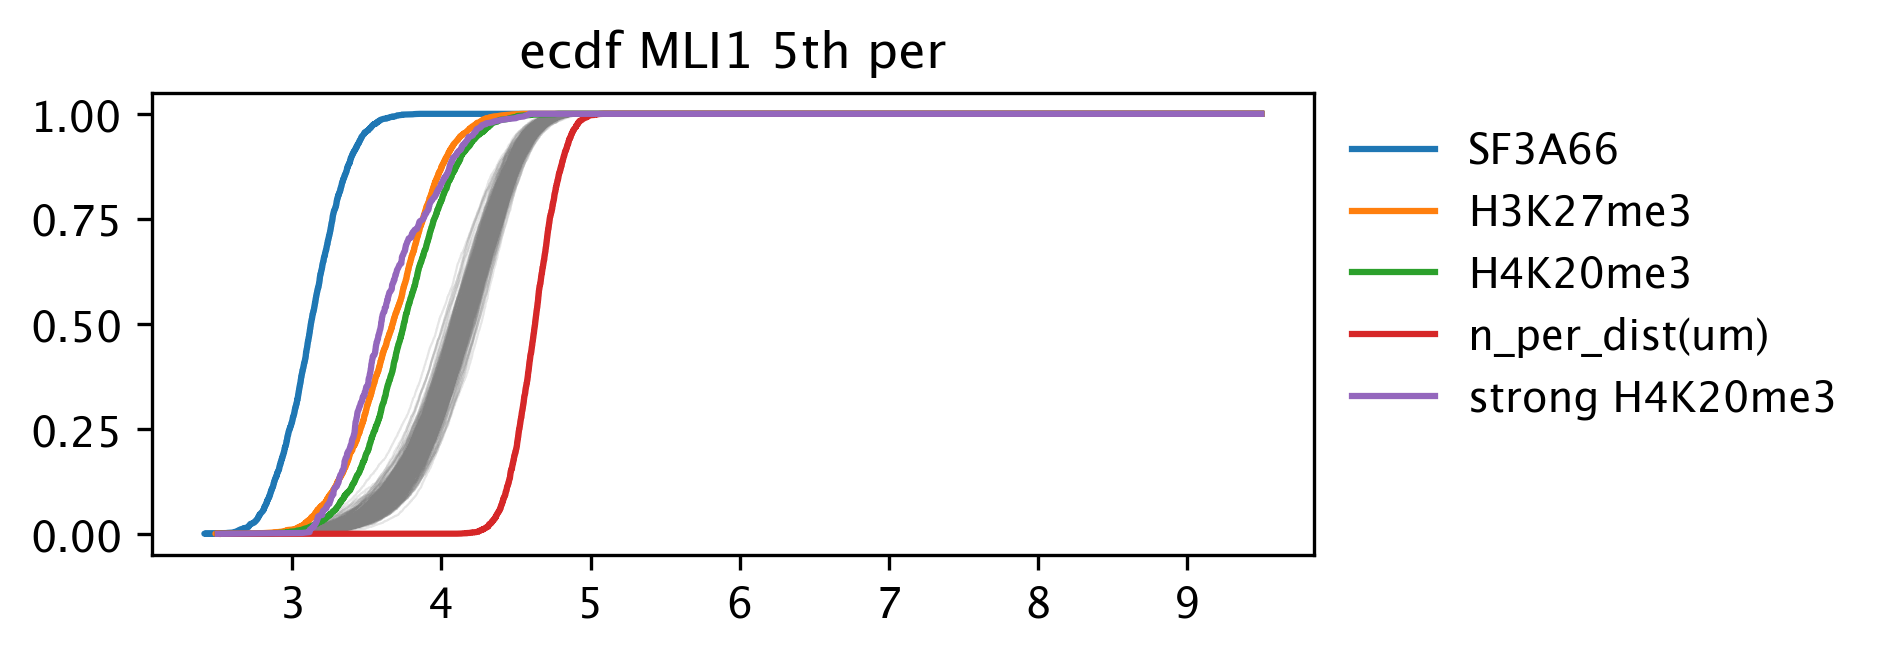

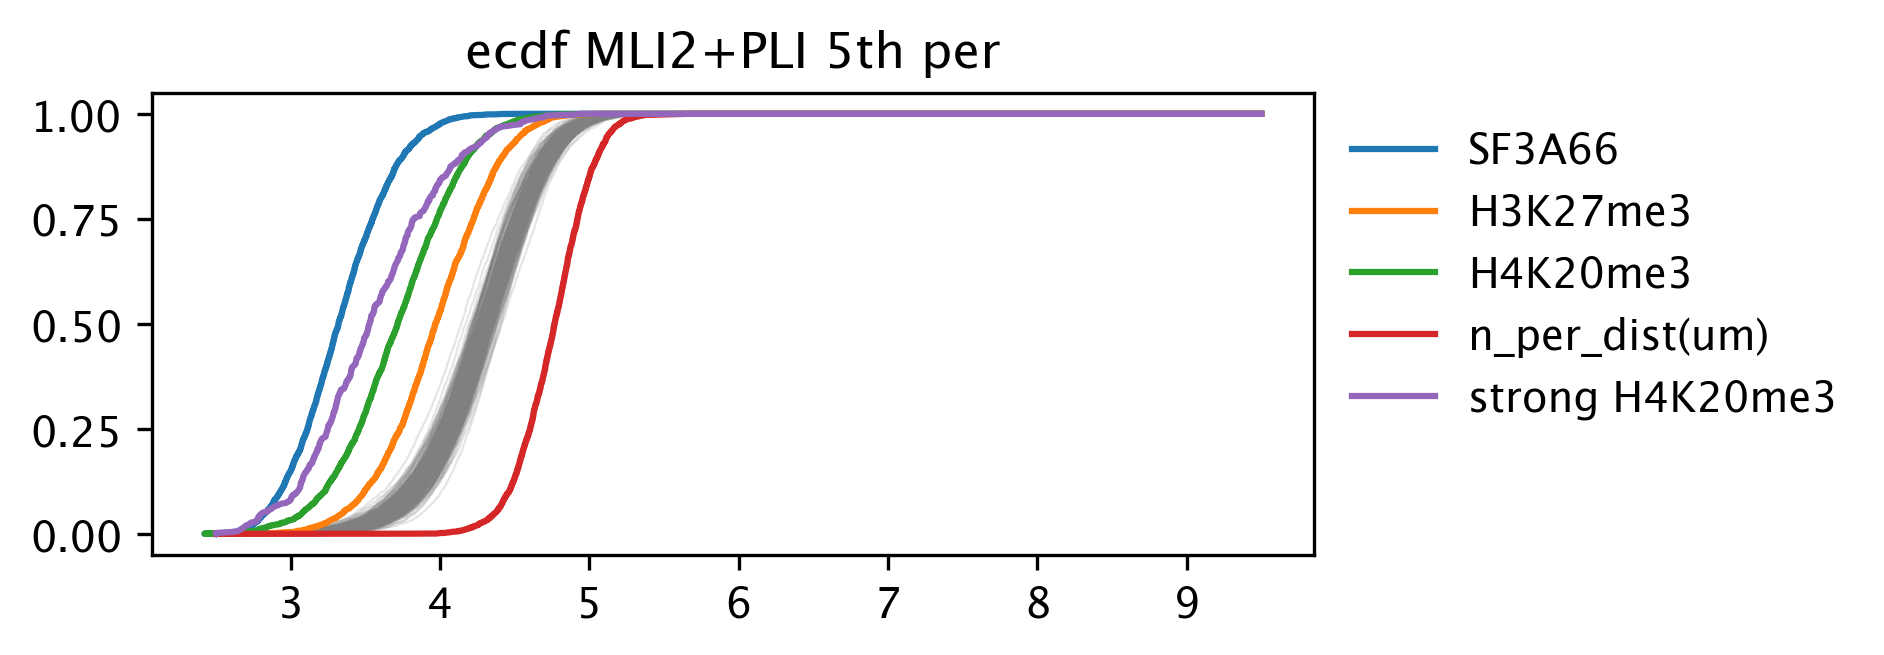

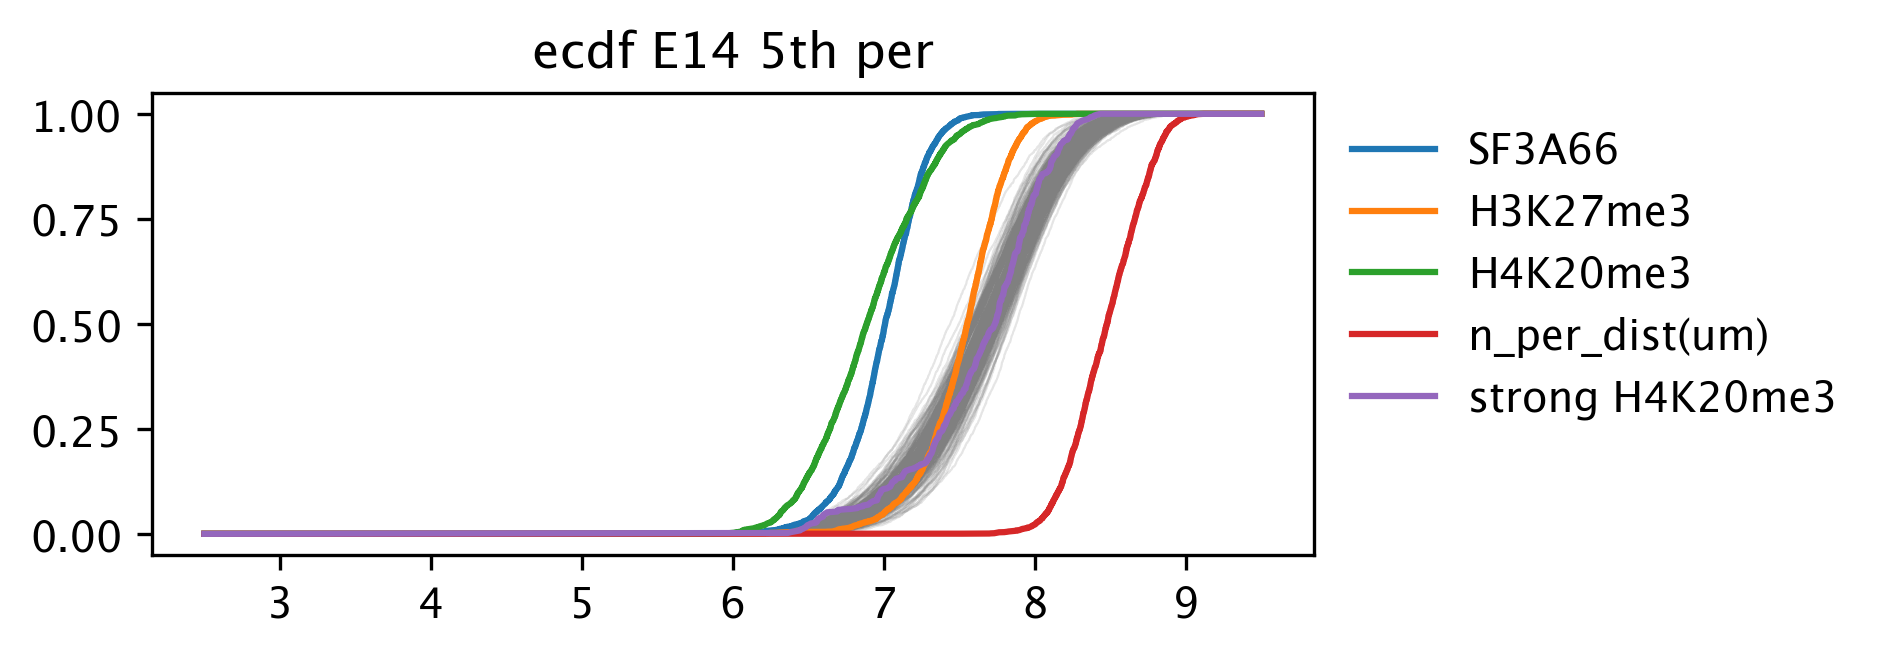

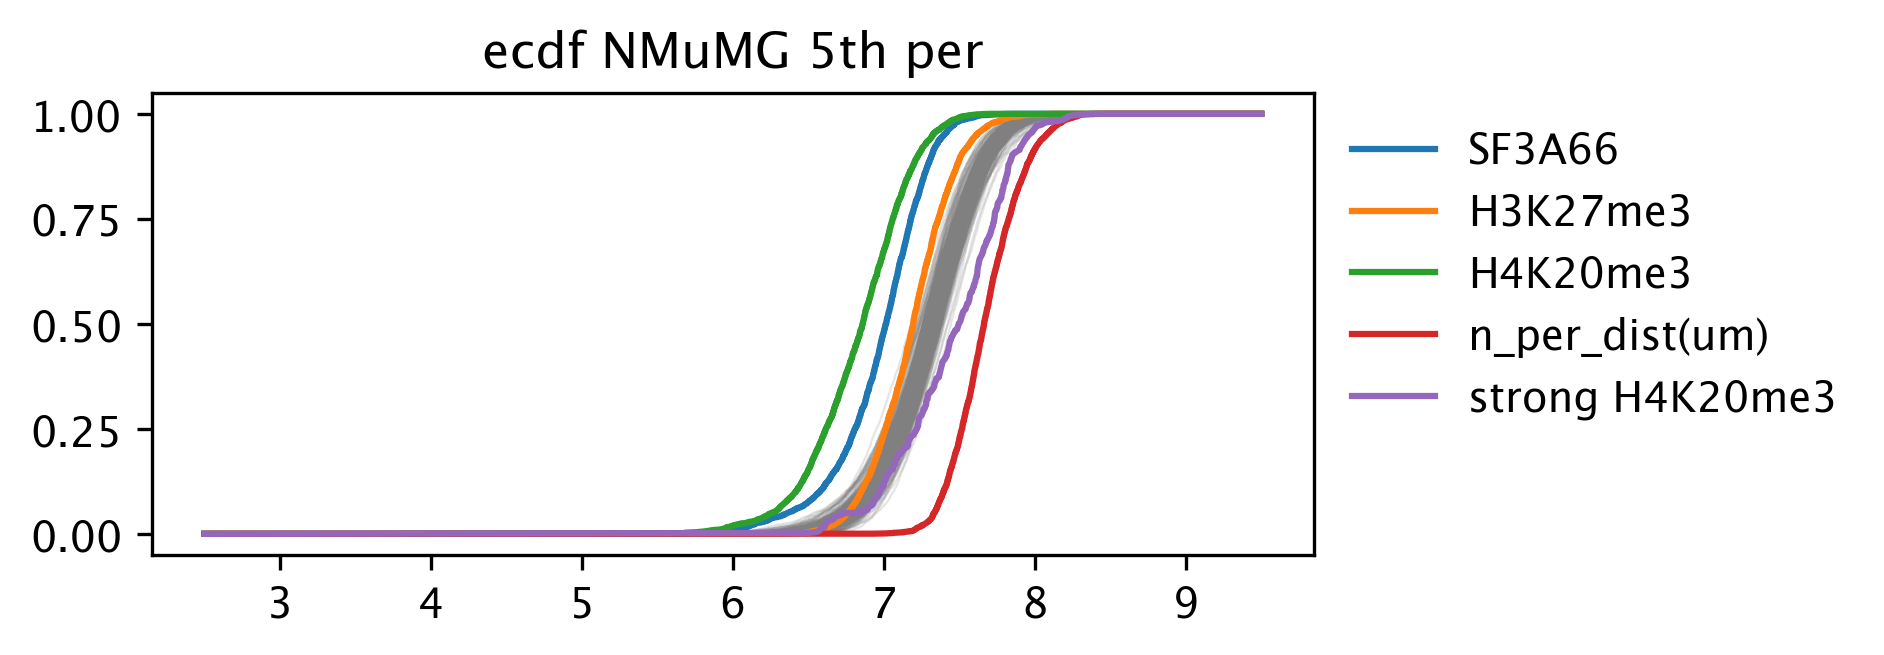

In [71]:
# ecdf plot example
x_min = 2.5
x_max = 9.5

for ct in cell_types_all:
    plt.figure(figsize = (5, 2))
    # a is the data array
    for bs in bs_5per[ct]["array"]:
        x, y = calc_ecdf(bs)
        # add x min 
        x = np.hstack(([x_min], x, [x_max]))
        y = np.hstack(([0], y, [1]))

        plt.plot(x, y, color = "grey", linewidth = 0.5, alpha = 0.05)
    ######################### change the markers here ##############################
    for m in ["SF3A66", "H3K27me3", "H4K20me3", "n_per_dist(um)", "strong H4K20me3"]:
        x, y = calc_ecdf(IF_5per[ct][m][0])
        x = np.hstack(([x_min], x, [x_max]))
        y = np.hstack(([0], y, [1]))
        plt.plot(x, y, label = m, linewidth = 1.5, alpha = 1)
    plt.legend(frameon = False, bbox_to_anchor= (1, 1))
    plt.title(f"ecdf {ct} 5th per")

# ECDF plot of extended Fig 10C

/Users/yujing/miniconda3/lib/python3.8/site-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


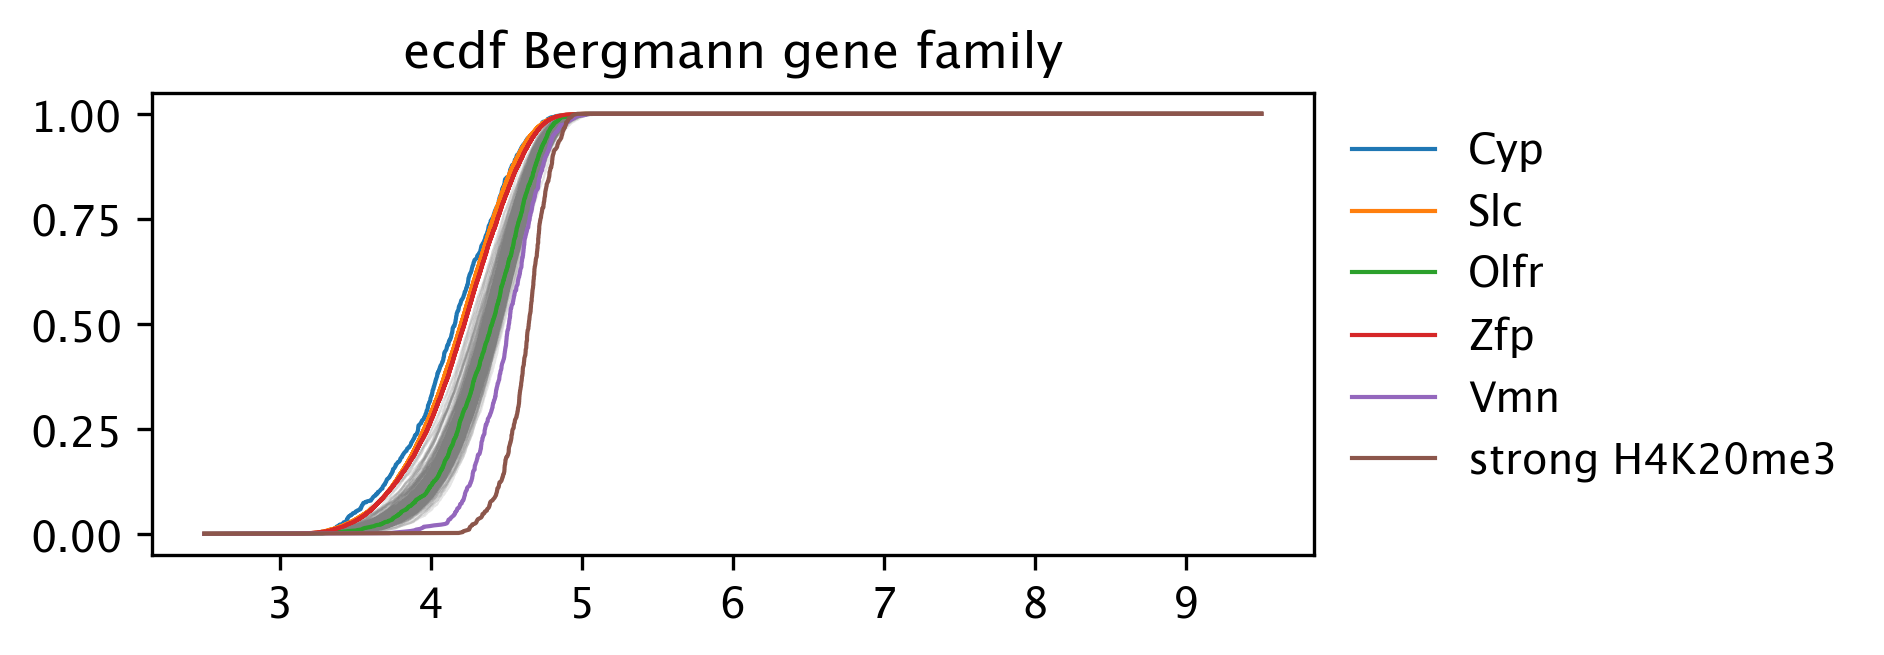

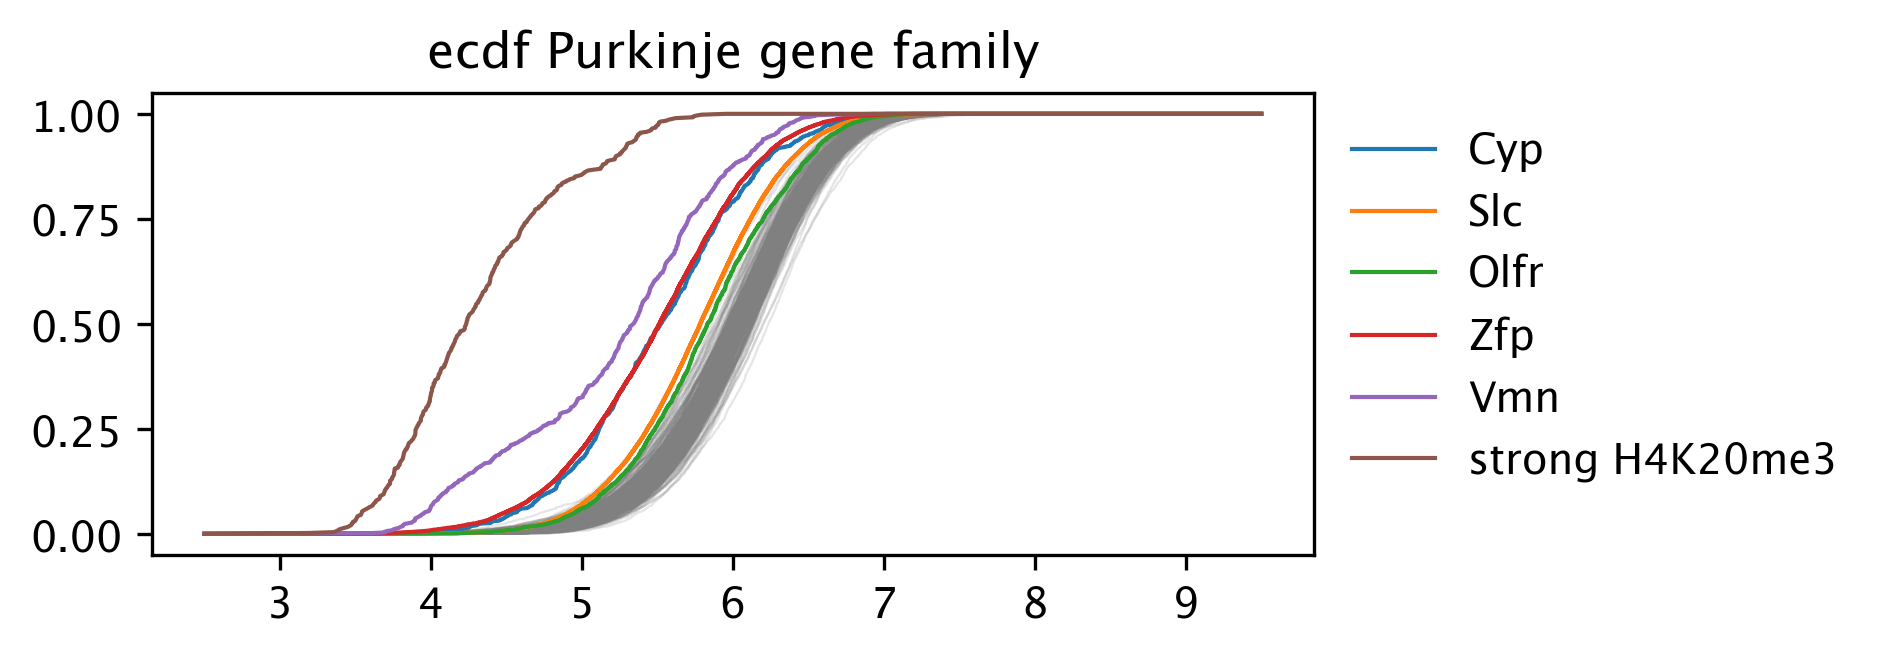

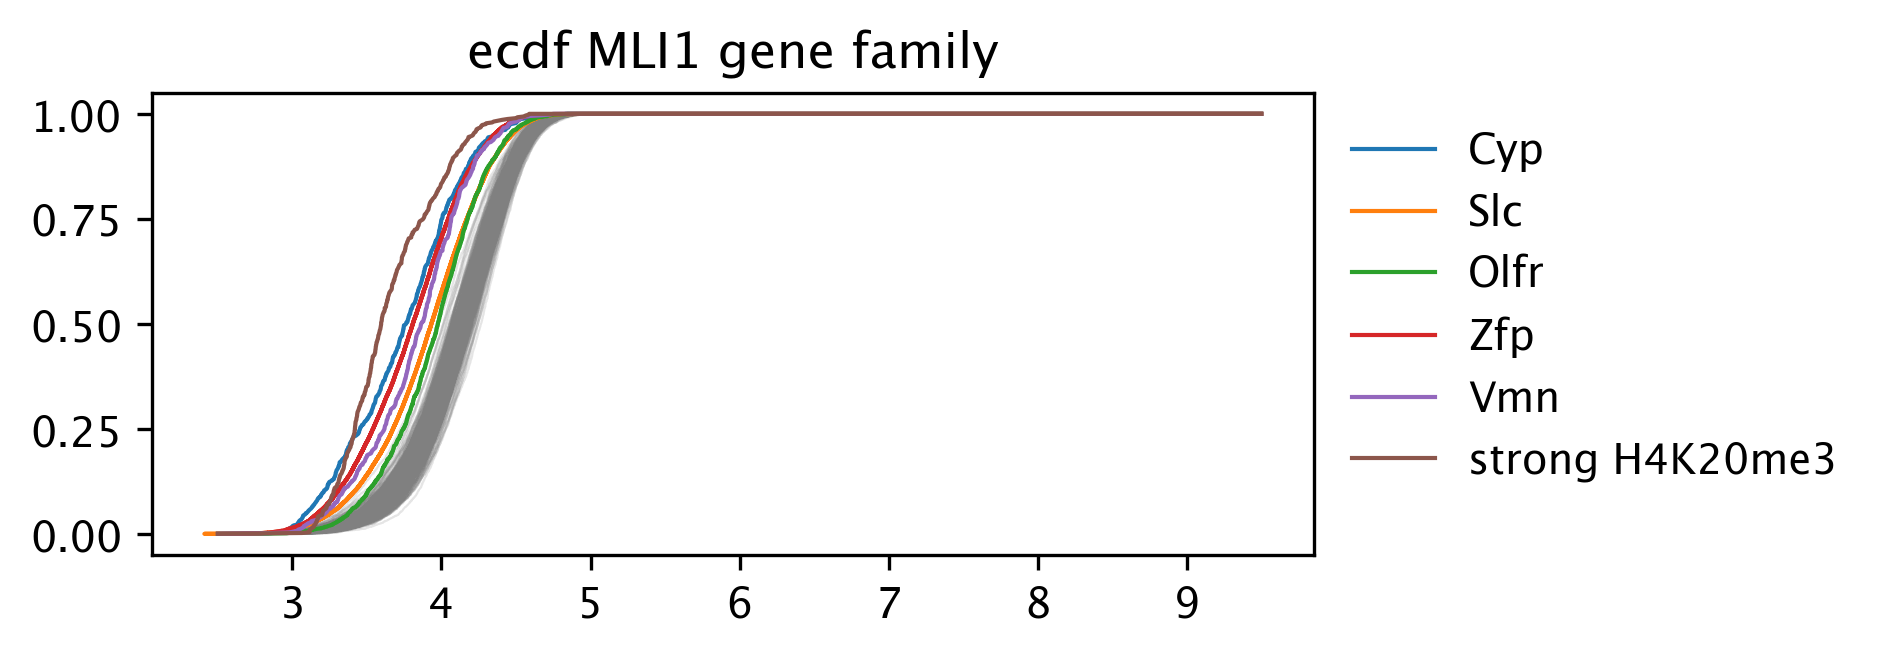

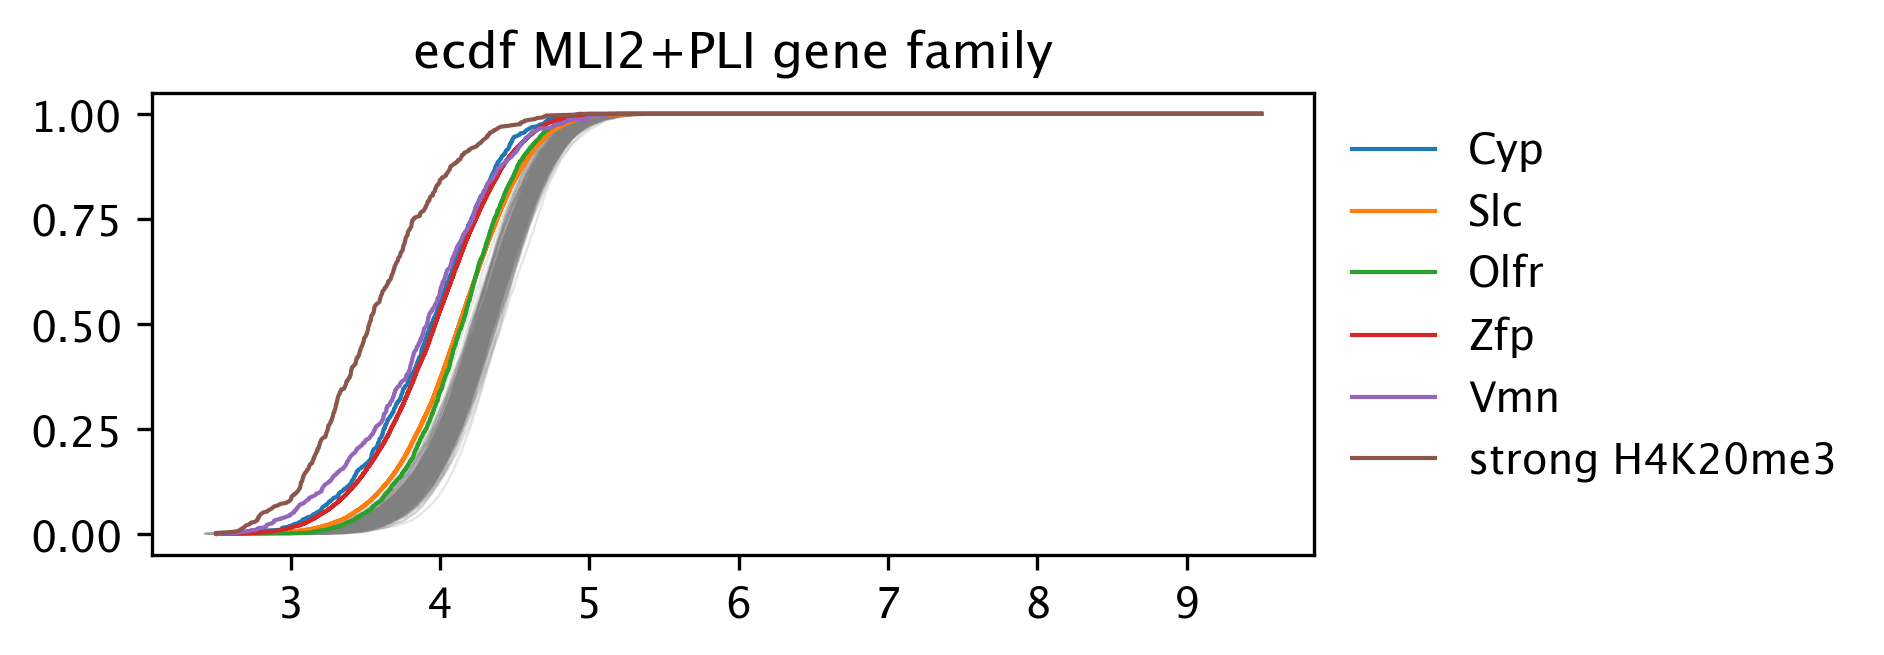

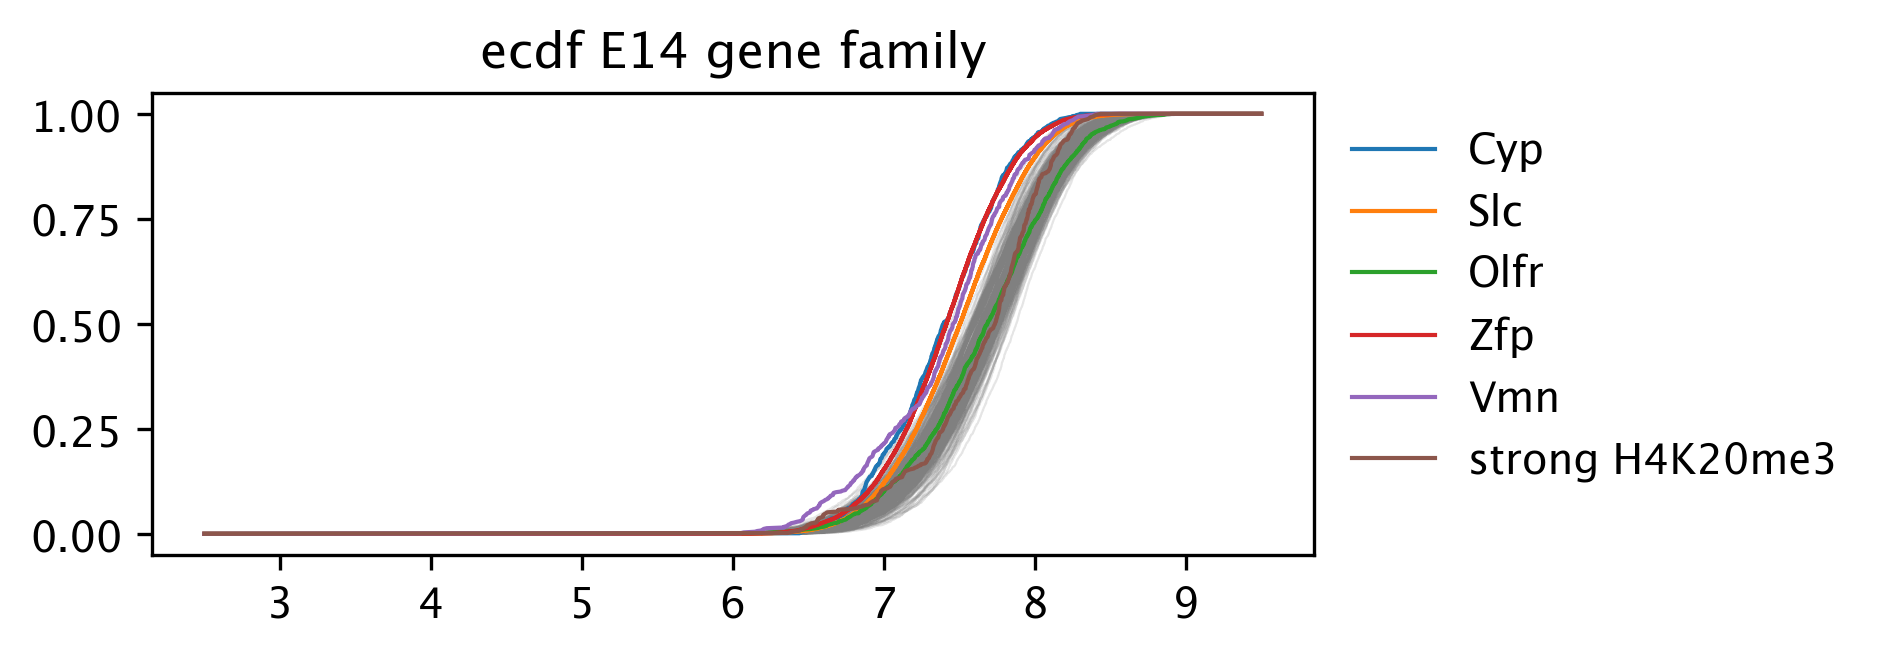

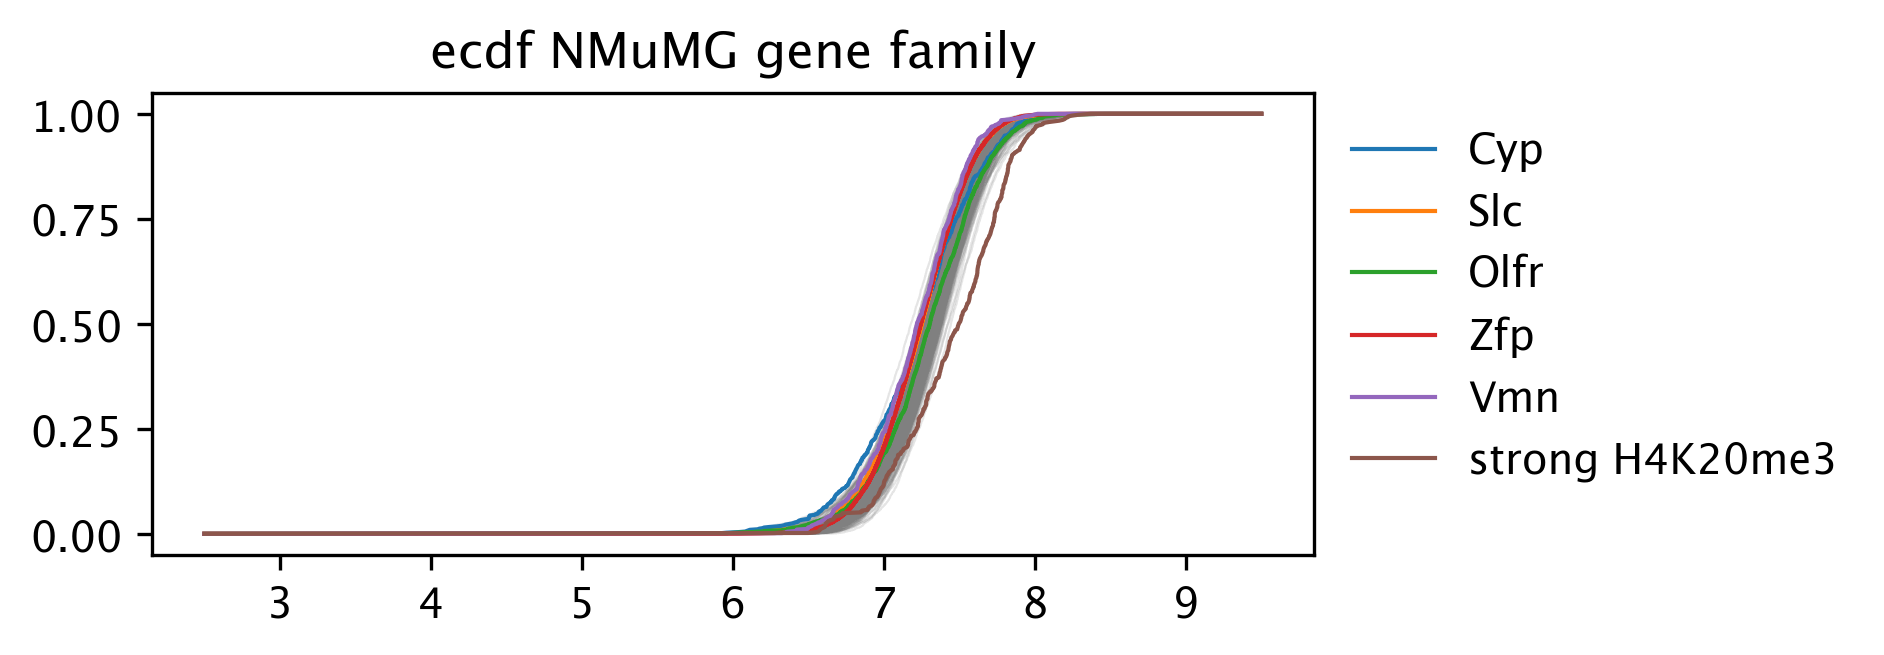

In [72]:
# ecdf plot
# try to plot all bootstrap
# set x_min and x_max for all markers to have the same start and end, for better visualization result
# you can change the range by setting xlim, each cell type has different lim though
x_min = 2.5
x_max = 9.5

for ct in cell_types_all:
    plt.figure(figsize = (5, 2))
    # a is the data array
    for bs in bs_5per[ct]["array"]:
        x, y = calc_ecdf(bs)
        # add x min 
        x = np.hstack(([x_min], x, [x_max]))
        y = np.hstack(([0], y, [1]))

        plt.plot(x, y, color = "grey", linewidth = 0.5, alpha = 0.05)
    ######################### change the markers here ##############################
    for gf in ["Cyp", "Slc", "Olfr", "Zfp", "Vmn", "strong H4K20me3"]:
        x, y = calc_ecdf(gf_dist[ct][gf][0])
        x = np.hstack(([x_min], x, [x_max]))
        y = np.hstack(([0], y, [1]))
        plt.plot(x, y, label = gf, linewidth = 1, alpha = 1)
    plt.legend(frameon = False, bbox_to_anchor= (1, 1))
    plt.title(f"ecdf {ct} gene family")